In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import statsmodels.api as sm

movies_full = pd.read_csv('data/imdb1000_data.csv')

# Dataset Description: IMDb Top 1000 Movies

This dataset contains information about the top 1000 movies rated on IMDb. Below is a description of each column:

| Column | Description |
|--------|-------------|
| **Poster_Link** | URL to the movie poster image on IMDb |
| **Series_Title** | Title of the movie |
| **Released_Year** | Year in which the movie was released |
| **Certificate** | Rating certificate (e.g., A, U, UA) |
| **Runtime** | Total runtime of the movie in minutes |
| **Genre** | Categories/genres the movie belongs to |
| **IMDB_Rating** | Movie rating on IMDb (scale of 1-10) |
| **Overview** | Brief summary or plot description of the movie |
| **Meta_score** | Score earned on Metacritic (scale of 1-100) |
| **Director** | Name of the movie's director |
| **Star1** | Name of the lead actor/actress |
| **Star2** | Name of the second lead actor/actress |
| **Star3** | Name of the third lead actor/actress |
| **Star4** | Name of the fourth lead actor/actress |
| **No_of_Votes** | Total number of votes received on IMDb |
| **Gross** | Box office earnings of the movie in dollars |

The dataset contains 1000 entries with 16 columns. Some columns like Certificate (10.1% missing) and Meta_score (15.7% missing) contain null values.

In [35]:
movies = movies_full.drop(columns=['Poster_Link', 'Overview', 'Star1', 'Star2', 'Star3', 'Star4', 'Director', 'No_of_Votes'])
movies = movies.set_index('Series_Title')
movies.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Gross
Series_Title,,,,,,,
The Shawshank Redemption,1994,A,142 min,Drama,9.3,80.0,"28,341,469"
The Godfather,1972,A,175 min,"Crime, Drama",9.2,100.0,"134,966,411"
The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,84.0,"534,858,444"
The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,90.0,"57,300,000"
12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,96.0,"4,360,000"


In [36]:
movies['Released_Year'] = pd.to_numeric(movies['Released_Year'], errors='coerce')
movies['Released_Year'].dropna().unique()
movies['Runtime'] = movies['Runtime'].str.split(' ').str[0].astype(int)
movies['Gross'] = movies['Gross'].str.replace(',', '')
movies['Gross'] = pd.to_numeric(movies['Gross'], errors='coerce')
movies

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Gross
Series_Title,,,,,,,
The Shawshank Redemption,1994.0,A,142,Drama,9.3,80.0,28341469.0
The Godfather,1972.0,A,175,"Crime, Drama",9.2,100.0,134966411.0
The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,84.0,534858444.0
The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,90.0,57300000.0
12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,96.0,4360000.0
...,...,...,...,...,...,...,...
Breakfast at Tiffany's,1961.0,A,115,"Comedy, Drama, Romance",7.6,76.0,NaN
Giant,1956.0,G,201,"Drama, Western",7.6,84.0,NaN
From Here to Eternity,1953.0,Passed,118,"Drama, Romance, War",7.6,85.0,30500000.0


In [37]:
movies['Certificate'].unique()

array(['A', 'UA', 'U', 'PG-13', 'R', nan, 'PG', 'G', 'Passed', 'TV-14',
       '16', 'TV-MA', 'Unrated', 'GP', 'Approved', 'TV-PG', 'U/A'],
      dtype=object)

In [38]:
print('The number of missing values: ')
for item in movies.columns:
    print(f'{item} - {movies[item].isnull().sum()}')

The number of missing values: 
Released_Year - 1
Certificate - 101
Runtime - 0
Genre - 0
IMDB_Rating - 0
Meta_score - 157
Gross - 169


In [39]:
movies.sort_values(by='Released_Year', ascending=False).head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Gross
Series_Title,,,,,,,
Druk,2020.0,NaN,117,"Comedy, Drama",7.8,81.0,NaN
Hamilton,2020.0,PG-13,160,"Biography, Drama, History",8.6,90.0,NaN
Dil Bechara,2020.0,UA,101,"Comedy, Drama, Romance",7.9,NaN,NaN
Soul,2020.0,U,100,"Animation, Adventure, Comedy",8.1,83.0,NaN
The Trial of the Chicago 7,2020.0,R,129,"Drama, History, Thriller",7.8,77.0,NaN


In [40]:
meta_score = movies['Meta_score']
imdb_score = movies['IMDB_Rating'] * 10
critics_score = pd.concat([meta_score, imdb_score], axis=1)
critics_score = critics_score.dropna()
critics_score.describe()

,Meta_score,IMDB_Rating
count,843.000000,843.000000
mean,77.971530,79.316726
std,12.376099,2.837322
min,28.000000,76.000000
25%,70.000000,77.000000
50%,79.000000,79.000000
75%,87.000000,81.000000
max,100.000000,93.000000


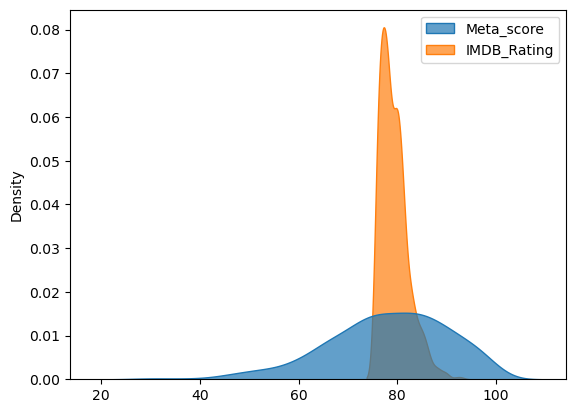

In [41]:
sns.kdeplot(data=critics_score, fill=True, alpha=0.7)
plt.show()

# T-testing
There is a statistically significant difference between IMDb and Metacritic scores for the movies analyzed. The p-value (0.0021) is much smaller than the standard threshold of 0.05, meaning the difference is unlikely to be due to random chance.

In [42]:
t_test = sp.ttest_ind(critics_score["IMDB_Rating"], critics_score["Meta_score"], alternative = "two-sided")
t_test.pvalue

0.002131446476396098

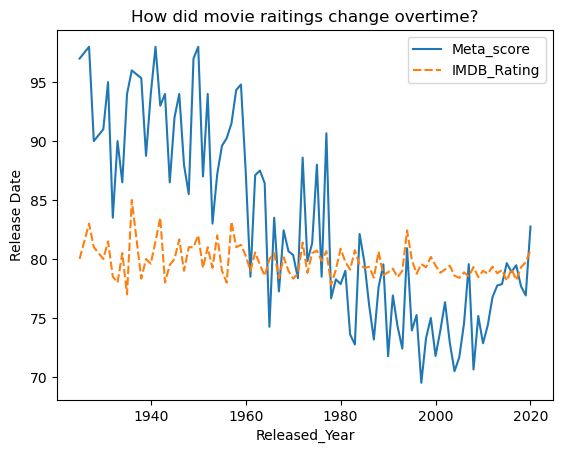

In [43]:
movies_time = pd.concat([meta_score, imdb_score, movies['Released_Year']], axis=1).dropna()

movies_by_year = movies_time.groupby('Released_Year').agg({
	'Meta_score': 'mean',
	'IMDB_Rating': 'mean'
}).reset_index()

movies_by_year = movies_by_year.set_index('Released_Year')
sns.lineplot(data=movies_by_year)
plt.title('How did movie raitings change overtime?')
plt.ylabel('Movie raiting')
plt.ylabel('Release Date')
plt.show()

Ttest here

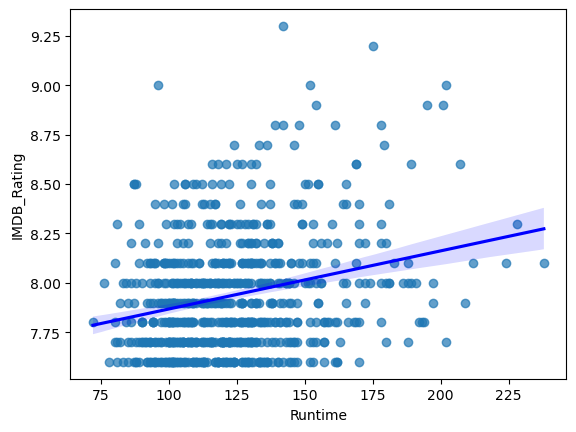

In [63]:
# use the code below for plotting any linear relationships, e.g if we want to check if the control variables are colinear
sns.regplot(x = movies['Runtime'] , y = movies['IMDB_Rating'] , scatter_kws={'alpha':0.7}, line_kws={'color': 'blue'})
plt.show()

In [60]:
#then I had an idea of a way to include ‘certificate’ in the model, by converting it to a categorical variable with only two options- Kids and Adult
#Couldn’t quite get the code to work, but will try again later
movies = movies.dropna()

print(movies['Certificate'].unique())
kid_movies = ['U/A' , 'U' , 'PG-13' , 'PG' ,'TV-PG', 'G' ,'Passed', 'Approved']
adult_movies = ['A', 'UA', 'R', '16', 'TV-14', 'GP', 'TV-MA', 'Unrated']
def classify_cert(row):
    if row in kid_movies:
        return 'kid'
    elif row in adult_movies:
        return 'adult'
    else:
        print('There is a NaN value')
        return np.nan

['A' 'UA' 'U' 'R' 'G' 'PG-13' 'PG' 'Passed' 'Approved' 'TV-PG' 'U/A' 'GP']


In [61]:
movies = movies.copy()
movies['Certificate_category'] = movies['Certificate'].apply(classify_cert)
movies

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Gross,Certificate_category
Series_Title,,,,,,,,
The Shawshank Redemption,1994.0,A,142,Drama,9.3,80.0,28341469.0,adult
The Godfather,1972.0,A,175,"Crime, Drama",9.2,100.0,134966411.0,adult
The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,84.0,534858444.0,adult
The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,90.0,57300000.0,adult
12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,96.0,4360000.0,kid
...,...,...,...,...,...,...,...,...
Giù la testa,1971.0,PG,157,"Drama, War, Western",7.6,77.0,696690.0,kid
Kelly's Heroes,1970.0,GP,144,"Adventure, Comedy, War",7.6,50.0,1378435.0,adult
The Jungle Book,1967.0,U,78,"Animation, Adventure, Family",7.6,65.0,141843612.0,kid


In [62]:
formula_string = "IMDB_Rating ~ Runtime + Certificate_category + Gross + Released_Year"
model = sm.formula.ols(formula = formula_string, data = movies)
model_fitted = model.fit()

model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMDB_Rating   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     22.88
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           8.51e-18
Time:                        18:29:07   Log-Likelihood:                -93.114
No. Observations:                 713   AIC:                             196.2
Df Residuals:                     708   BIC:                             219.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      14.2231      1.197     11.883      0.000      11.873      16.573
Certificate_category[T.kid]    -0.0136      0.022     -0.604      0.546      -0.058       0.031
Runtime                         0.0026      0.000      6.317      0.000       0.002       0.003
Gross                         3.51e-10   9.44e-11      3.717      0.000    1.66e-10    5.36e-10
Released_Year                  -0.0033      0.001     -5.569      0.000      -0.004      -0.002
==============================================================================
Omnibus:                      101.701   Durbin-Watson:                   0.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.120
Skew:                           0.980   Prob(JB):                     2.52e-33
Kurtosis:                       4.102   Cond. No.                     1.61e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

continue working on this